<a href="https://colab.research.google.com/github/meka-williams/Capstone-Finance-AI-Project/blob/main/Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The Lost Boy:
#The Hull moving average and the Directional Moving Index (ADX)

In [15]:
#imports

import requests
from google.colab import userdata
import os, json
from datetime import datetime
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [8]:
#API setup

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

API_KEY = os.getenv("ALPHAVANTAGE_API_KEY", "GPOTJ4638HWF4A6H")
BASE_URL = "https://www.alphavantage.co/query"

In [9]:
#initial data fetch

def _fetch_json(params, retries=3, sleep_s=15):

    for i in range(retries):
        r = requests.get(BASE_URL, params=params, timeout=30)
        r.raise_for_status()
        payload = r.json()

        #return if valid data was retrieved
        if any("Time Series" in k for k in payload.keys()):
            return payload

        #API limit error
        if "Note" in payload and i < retries - 1:
            print("The API limit has been hit, retrying")
            time.sleep(sleep_s)
            continue

        #payload for debugging
        return payload
    return payload


In [10]:
#time series fetch - 5 minute interval used to show volatility


def fetch_intraday(symbol: str, interval: str = "5min", outputsize: str = "compact") -> pd.DataFrame:
    """
    Returns DataFrame indexed by datetime with numeric columns.
    """

    params = {
        "function": "TIME_SERIES_INTRADAY",
        "symbol": symbol,
        "interval": interval,
        "outputsize": outputsize,
        "apikey": API_KEY,
    }

    #data fetch
    payload = _fetch_json(params)
    key = next((k for k in payload.keys() if "Time Series" in k), None)
    if not key:
        raise ValueError(f"Unexpected API response for {symbol}: {payload}")

    df = pd.DataFrame(payload[key]).T
    df.index = pd.to_datetime(df.index)
    df = df.rename(columns=lambda c: c.split(". ", 1)[-1])  # "1. open" -> "open"
    df = df.apply(pd.to_numeric, errors="coerce").sort_index()

    #save data to CSV
    out_path = DATA_DIR / f"{symbol}_{interval}_intraday.csv"
    df.to_csv(out_path)
    print(f"Downloaded {symbol} ({interval}): {len(df)} rows → {out_path}")
    print(f"Date range: {df.index.min()} → {df.index.max()}")

    return df


Enter a stock symbol (e.g., IBM, AAPL, MSFT): aapl
Downloaded AAPL (5min): 4224 rows → data/AAPL_5min_intraday.csv
Date range: 2025-09-08 04:00:00 → 2025-10-07 19:55:00

--- Sample of the extracted data ---
                       open    high     low   close  volume
2025-09-08 04:00:00  239.62  240.58  239.62  240.35    5802
2025-09-08 04:05:00  240.36  240.43  240.28  240.37    3587
2025-09-08 04:10:00  240.37  240.38  240.18  240.29    2945
2025-09-08 04:15:00  240.27  240.31  240.17  240.20    2358
2025-09-08 04:20:00  240.18  240.22  240.10  240.12    2711

--- Data summary ---
              open         high          low        close        volume
count  4224.000000  4224.000000  4224.000000  4224.000000  4.224000e+03
mean    246.356792   246.608852   245.864895   246.374861  3.468725e+05
std      10.168807    10.146776    10.446384    10.161494  2.211599e+06
min     219.337800   226.280000   195.270000   221.328100  2.600000e+01
25%     237.560000   237.789700   237.103750   237.

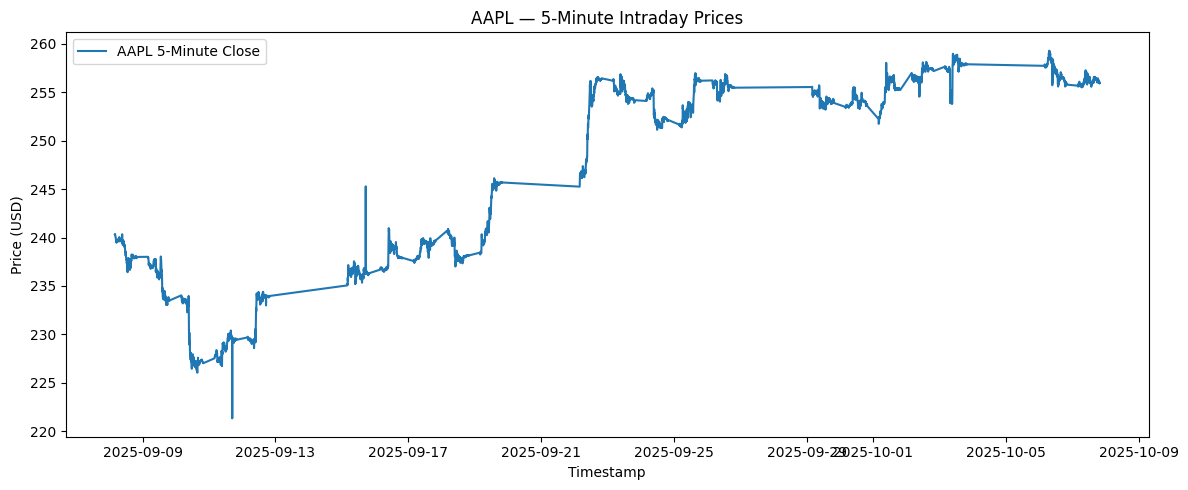

In [13]:
#initial test to validate data extraction

symbol = input("Enter a stock symbol (e.g., IBM, AAPL, MSFT): ").upper()
df = fetch_intraday(symbol, interval="5min", outputsize="full")

#show first 5 rows
print("\n--- Sample of the extracted data ---")
print(df.head())
print("\n--- Data summary ---")
print(df.describe())


#vis
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["close"], label=f"{symbol} 5-Minute Close", color="tab:blue")
plt.title(f"{symbol} — 5-Minute Intraday Prices")
plt.xlabel("Timestamp")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

=== Summary statistics ===
           open      high       low     close        volume
count  4224.000  4224.000  4224.000  4224.000  4.224000e+03
mean    246.357   246.609   245.865   246.375  3.468725e+05
std      10.169    10.147    10.446    10.161  2.211599e+06
min     219.338   226.280   195.270   221.328  2.600000e+01
25%     237.560   237.790   237.104   237.570  2.555000e+03
50%     252.195   252.310   251.616   252.195  1.535600e+04
75%     255.632   255.810   255.450   255.646  3.301878e+05
max     259.310   272.048   259.210   259.300  1.194788e+08


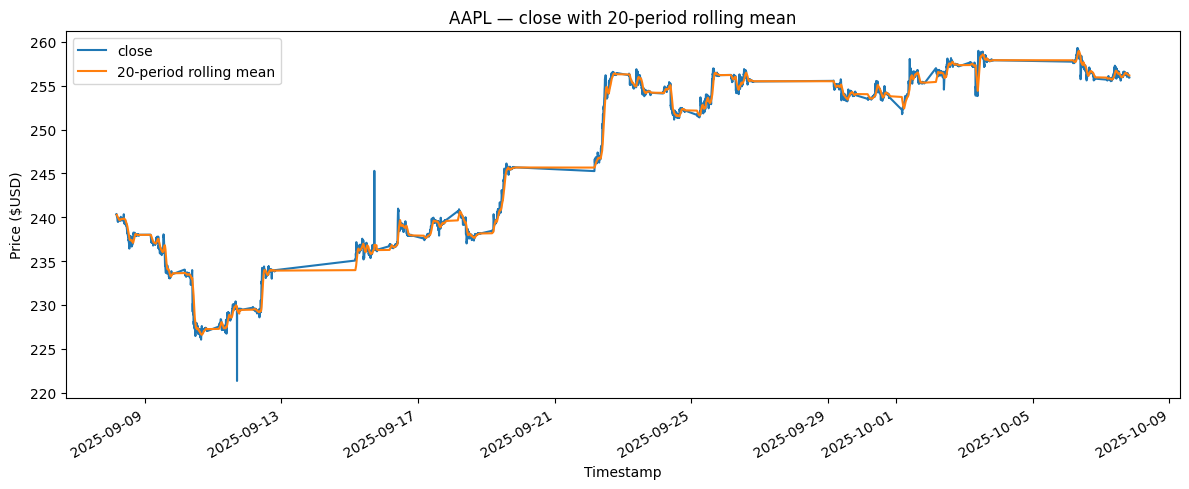

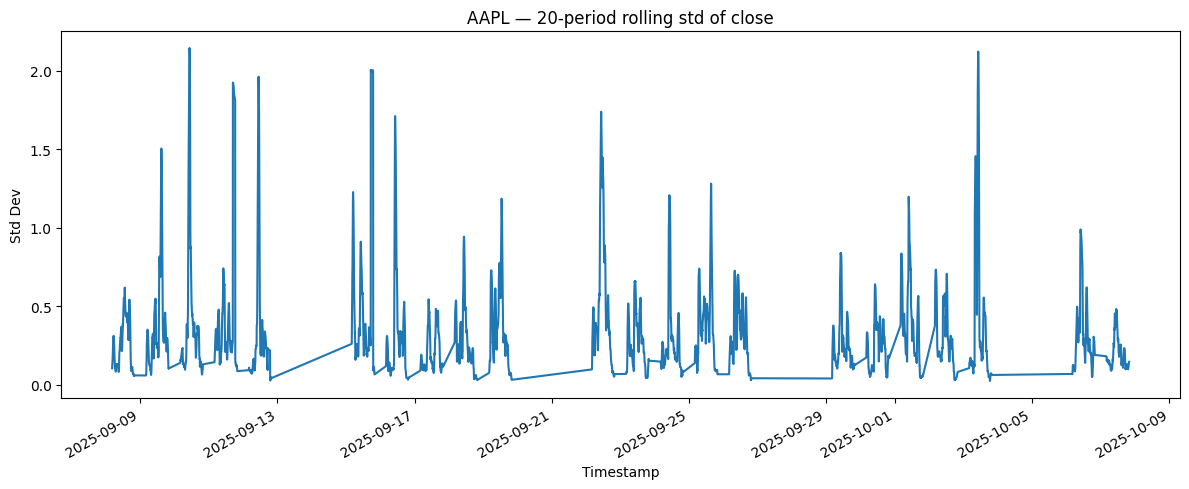

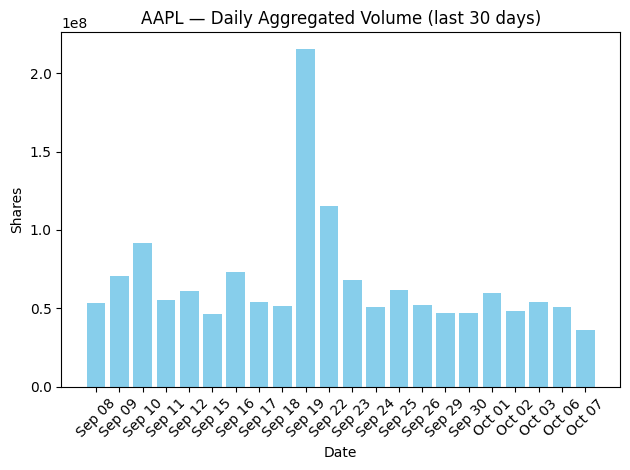

In [19]:
#exploratory visuals (line plot, rolling stats) + summary stats

price_col = "adjusted_close" if "adjusted_close" in df.columns else "close"

#rolling stats
rolling_window = 20
df["roll_mean_20"] = df[price_col].rolling(rolling_window, min_periods=5).mean()
df["roll_std_20"]  = df[price_col].rolling(rolling_window, min_periods=5).std()

#daily returns
df["return_1d"] = df[price_col].pct_change()


#summary stats
summary = df[["open","high","low",price_col,"volume"]].describe().round(3)
print("=== Summary statistics ===")
print(summary)

#save summary csv
DATA_DIR = Path("data")
summary.to_csv(DATA_DIR / f"{symbol}_summary_stats.csv")


#plots

#price with rolling mean
plt.figure(figsize=(12, 5))
df[price_col].plot(label=price_col)
df["roll_mean_20"].plot(label=f"{rolling_window}-period rolling mean")
plt.title(f"{symbol} — {price_col} with {rolling_window}-period rolling mean")
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Price ($USD)")
plt.tight_layout()
plt.show()


#rolling volatility proxy (std dev)
plt.figure(figsize=(12, 5))
df["roll_std_20"].plot()
plt.title(f"{symbol} — {rolling_window}-period rolling std of {price_col}")
plt.xlabel("Timestamp")
plt.ylabel("Std Dev")
plt.tight_layout()
plt.show()



#volume by day
df["date"] = df.index.date
daily_volume = df.groupby("date")["volume"].sum()

#last 30 trading days
daily_volume_last = daily_volume[-30:]

positions = range(len(daily_volume_last))
plt.bar(positions, daily_volume_last.values, color="skyblue")
plt.xticks(positions, [d.strftime("%b %d") for d in daily_volume_last.index], rotation=45)
plt.title(f"{symbol} — Daily Aggregated Volume (last 30 days)")
plt.xlabel("Date")
plt.ylabel("Shares")
plt.tight_layout()
plt.show()



In [ ]:
# Identifying Time Series Components

# Decompose the series into trend, seasonality, and residuals.
# Perform ACF and PACF analysis.
# Run stationarity tests (ADF).
# Report with plots and interpretations of time series characteristics.

=== TIME SERIES CHARACTERISTICS REPORT ===



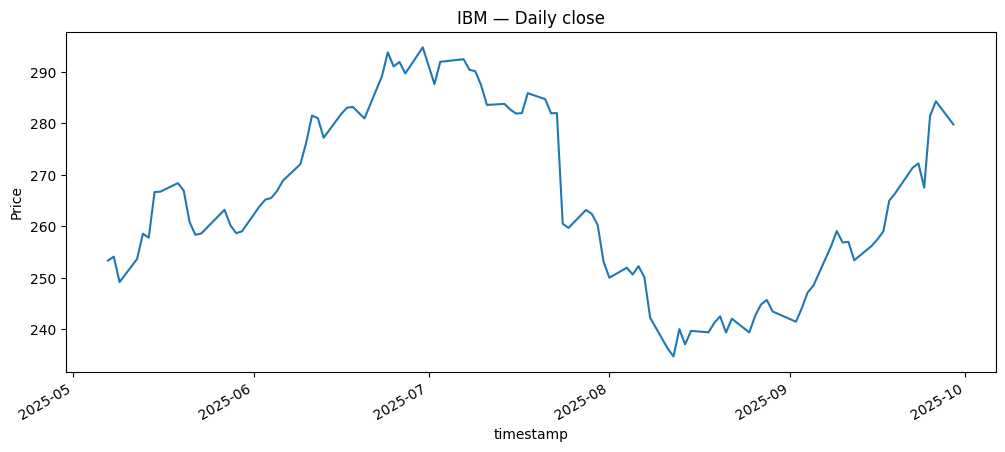

The raw price series shows an upward/downward drift and volatility clustering, suggesting it is likely non-stationary.


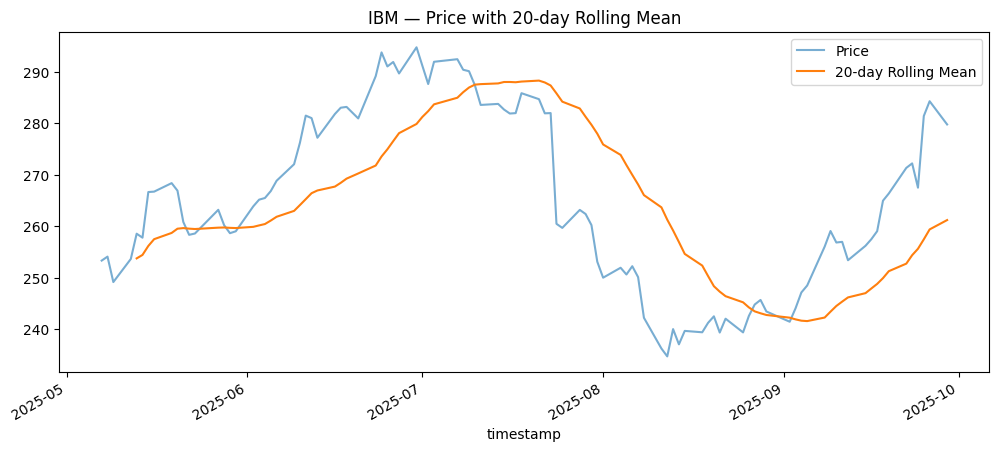

Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.


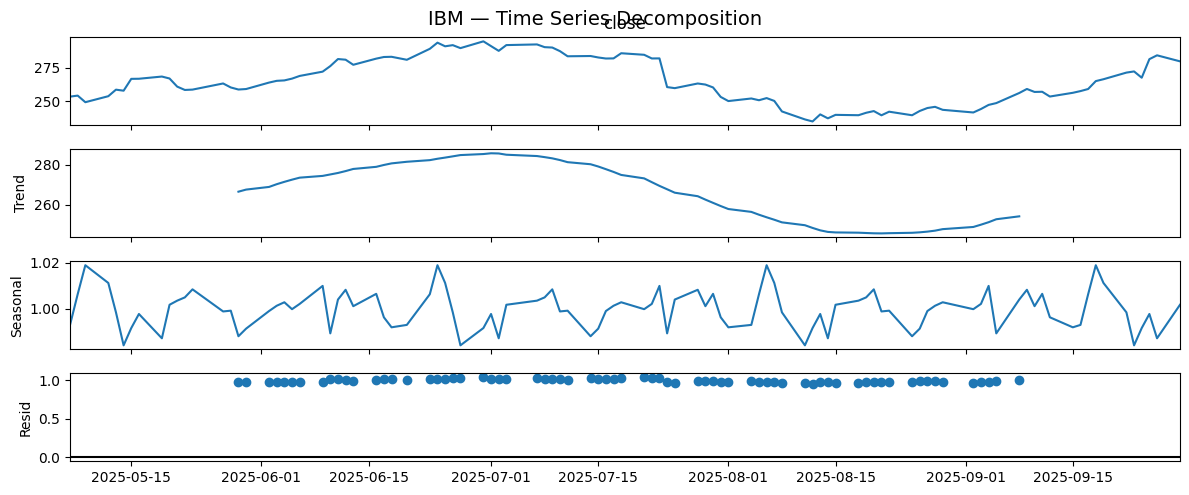

Decomposition separates the series into:
- Trend: Long-term direction of the stock price.
- Seasonality: Repeating short-term cycles (monthly/weekly effects).
- Residuals: Irregular noise not explained by trend or seasonality.



<Figure size 1000x400 with 0 Axes>

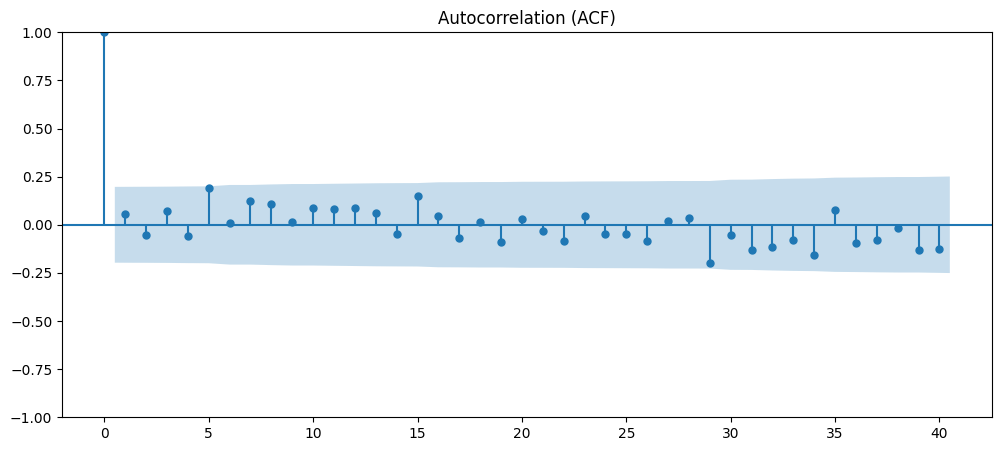

<Figure size 1000x400 with 0 Axes>

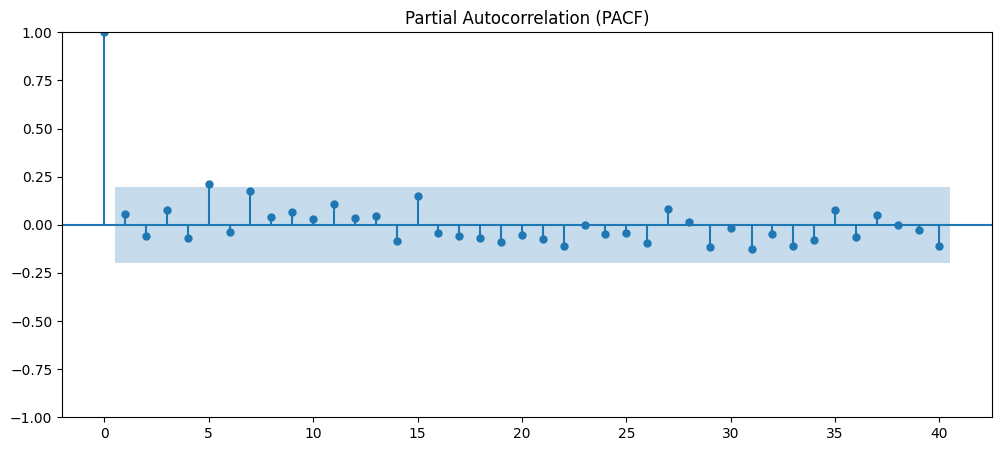

ACF shows correlations with past lags; PACF isolates direct effects of lags. These help identify ARIMA model orders.

=== Augmented Dickey-Fuller Test ===
ADF Statistic: -9.2107
p-value      : 0.0000
Critical Values: {'1%': np.float64(-3.4989097606014496), '5%': np.float64(-2.891516256916761), '10%': np.float64(-2.5827604414827157)}
✅ The series is stationary (reject null hypothesis).


In [ ]:
import matplotlib.pyplot as plt

print("=== TIME SERIES CHARACTERISTICS REPORT ===\n")

# 1) Plot the raw series
plt.figure(figsize=(12, 5))
df[price_col].plot(title=f"{symbol} — Daily {price_col}")
plt.ylabel("Price")
plt.show()
print("The raw price series shows an upward/downward drift and volatility clustering, "
      "suggesting it is likely non-stationary.")

# 2) Plot rolling stats
plt.figure(figsize=(12, 5))
df[price_col].plot(label="Price", alpha=0.6)
df["roll_mean_20"].plot(label="20-day Rolling Mean")
plt.title(f"{symbol} — Price with 20-day Rolling Mean")
plt.legend()
plt.show()
print("Rolling mean smooths out daily fluctuations, helping visualize the underlying trend.")

# 3) Decomposition (Trend/Seasonality/Residuals)
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df[price_col].dropna(), model="multiplicative", period=30)
result.plot()
plt.suptitle(f"{symbol} — Time Series Decomposition", fontsize=14)
plt.show()
print("Decomposition separates the series into:\n"
      "- Trend: Long-term direction of the stock price.\n"
      "- Seasonality: Repeating short-term cycles (monthly/weekly effects).\n"
      "- Residuals: Irregular noise not explained by trend or seasonality.\n")

# 4) ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(10, 4))
plot_acf(df['return_1d'].dropna(), lags=40)
plt.title("Autocorrelation (ACF)")
plt.show()

plt.figure(figsize=(10, 4))
plot_pacf(df['return_1d'].dropna(), lags=40, method="ywm")
plt.title("Partial Autocorrelation (PACF)")
plt.show()
print("ACF shows correlations with past lags; PACF isolates direct effects of lags. "
      "These help identify ARIMA model orders.")

# 5) ADF Test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['return_1d'].dropna(), autolag='AIC')
print("\n=== Augmented Dickey-Fuller Test ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value      : {adf_result[1]:.4f}")
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("✅ The series is stationary (reject null hypothesis).")
else:
    print("❌ The series is non-stationary (fail to reject null). Differencing needed.")

In [ ]:
# Dealing with Non-Stationarity & Modeling

# Apply differencing, transformations, or detrending as needed.
# Implement and compare MA, AR, and ARIMA models.
# Evaluate model accuracy (e.g., AIC, BIC, RMSE).
# Provide consulting-style recommendations to your client.

In [ ]:
# Apply Differencing / Transformations

import numpy as np

# Log-transform (helps stabilize variance)
df["log_price"] = np.log(df[price_col])

# First difference of log price (approx daily returns)
df["diff_log_price"] = df["log_price"].diff()

# Drop NaNs
stationary_series = df["diff_log_price"].dropna()

# Re-run ADF test
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(stationary_series, autolag="AIC")

print("=== ADF on Differenced Log Price ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value      : {adf_result[1]:.4f}")

=== ADF on Differenced Log Price ===
ADF Statistic: -9.1996
p-value      : 0.0000


In [ ]:
# AR, MA, ARIMA Models

from statsmodels.tsa.arima.model import ARIMA

results = {}

# AR(1) model
model_ar = ARIMA(stationary_series, order=(1,0,0))
fit_ar = model_ar.fit()
results["AR(1)"] = fit_ar

# MA(1) model
model_ma = ARIMA(stationary_series, order=(0,0,1))
fit_ma = model_ma.fit()
results["MA(1)"] = fit_ma

# ARIMA(1,1,1) model (includes differencing)
model_arima = ARIMA(df[price_col], order=(1,1,1))
fit_arima = model_arima.fit()
results["ARIMA(1,1,1)"] = fit_arima

# Compare summary outputs
for name, model in results.items():
    print(f"\n=== {name} ===")
    print(model.summary())


=== AR(1) ===
                               SARIMAX Results                                
Dep. Variable:         diff_log_price   No. Observations:                   99
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 270.340
Date:                Tue, 30 Sep 2025   AIC                           -534.679
Time:                        21:45:16   BIC                           -526.894
Sample:                             0   HQIC                          -531.530
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.517      0.605      -0.003       0.005
ar.L1          0.0571      0.149      0.383      0.702      -0.235       0.349
sigma2         0.0002   1.92e-05     

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
# Evaluate Model Accuracy (fixed: align lengths)

from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

eval_rows = []

for name, model in results.items():
    aic = model.aic
    bic = model.bic

    # fitted values as a Pandas Series
    fitted = pd.Series(model.fittedvalues)

    # target (endogenous) series used by THIS model, with same index as fitted
    # (works across AR/MA on stationary_series and ARIMA on levels)
    try:
        endog = pd.Series(model.model.endog, index=fitted.index)
    except Exception:
        # Fallback: reindex your stationary series to fitted's index
        endog = pd.Series(stationary_series).reindex(fitted.index)

    # align & drop NaNs to ensure equal length
    aligned = pd.concat([endog.rename("y_true"), fitted.rename("y_hat")], axis=1).dropna()

    rmse = np.sqrt(mean_squared_error(aligned["y_true"], aligned["y_hat"]))
    n_used = len(aligned)

    eval_rows.append((name, aic, bic, rmse, n_used))

eval_df = pd.DataFrame(eval_rows, columns=["Model", "AIC", "BIC", "RMSE (in-sample)", "N used"])
print("=== Model Comparison (aligned) ===")
print(eval_df.sort_values(["AIC"]))

=== Model Comparison (aligned) ===
          Model         AIC         BIC  RMSE (in-sample)  N used
1         MA(1) -534.695697 -526.910337          0.015768      99
0         AR(1) -534.679494 -526.894135          0.015770      99
2  ARIMA(1,1,1)  565.194225  572.979584        265.235843      99
